* Ini dibuat sebelum merubah konsep app yang akan terus ngeretrain model


# Install / Import 

In [8]:
import sys
print(sys.version)

3.13.5 (v3.13.5:6cb20a219a8, Jun 11 2025, 12:23:45) [Clang 16.0.0 (clang-1600.0.26.6)]


In [2]:
#pip install torch torchvision torchaudio

In [3]:
#import torch

In [4]:
#pip install keras

In [5]:
#pip install tensorflow

In [6]:
#pip install pandas numpy matplotlib scikit-learn 

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle
from sklearn.preprocessing import MinMaxScaler


# Load Dataset

In [2]:
df = pd.read_csv('../Dataset/Historical/HistoricalData.csv')


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5430 entries, 0 to 5429
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  5430 non-null   int64  
 1   date        5430 non-null   object 
 2   price       5430 non-null   float64
 3   open        5430 non-null   float64
 4   high        5430 non-null   float64
 5   low         5430 non-null   float64
 6   volume      5430 non-null   float64
 7   change      5430 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 339.5+ KB


In [4]:
df.head(5)

,Unnamed: 0,date,price,open,high,low,volume,change
0,0,2010-07-18,0.1,0.0,0.1,0.1,80.0,0.0
1,1,2010-07-19,0.1,0.1,0.1,0.1,570.0,0.0
2,2,2010-07-20,0.1,0.1,0.1,0.1,260.0,0.0
3,3,2010-07-21,0.1,0.1,0.1,0.1,580.0,0.0
4,4,2010-07-22,0.1,0.1,0.1,0.1,2160.0,0.0


# preprocessing

In [44]:
 # Create features for prediction and avoid to modifying original data
df_processed = df.copy()
        
 # Adding technical indicators
df_processed['price_ma_7'] = df_processed['price'].rolling(window=7).mean() # -> 7-day moving average
df_processed['price_ma_30'] = df_processed['price'].rolling(window=30).mean() # -> 30-day moving average
df_processed['volatility'] = df_processed['price'].rolling(window=7).std() # -> 7-day rolling standard deviation
df_processed['volume_ma'] = df_processed['volume'].rolling(window=7).mean() # -> 7-day moving average of volume

# Create target variable (next day price)
df_processed['target'] = df_processed['price'].shift(-1) #  <-- Predicting next day's price

df_processed = df_processed.dropna()

feature_columns = ['price', 'open', 'high', 'low', 'volume', 'change', 
                  'price_ma_7', 'price_ma_30', 'volatility', 'volume_ma']

X = df_processed[feature_columns]
y = df_processed['target']
        
        
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

#  Training Model Regression (Linear Regression & Random Forest)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2, random_state=42, shuffle=False
)

In [8]:
# Model 1: Linear Regression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Model 2: Random Forest Regressor
rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train, y_train) 

RandomForestRegressor(random_state=42)

In [9]:
def eval_model(model, X, y, name):
    pred = model.predict(X)
    print(f"\n=== {name} ===")
    print("MAE :", mean_absolute_error(y, pred))
    print("RMSE:", np.sqrt(mean_squared_error(y, pred)))
    print("R²  :", r2_score(y, pred))

eval_model(linreg, X_test, y_test, "Linear Regression")
eval_model(rf_reg, X_test, y_test, "Random Forest Regressor")



=== Linear Regression ===
MAE : 910.2309543762158
RMSE: 1471.472632634483
R²  : 0.9972282545610707

=== Random Forest Regressor ===
MAE : 7179.885236111107
RMSE: 14334.858898596443
R²  : 0.7369515131252293


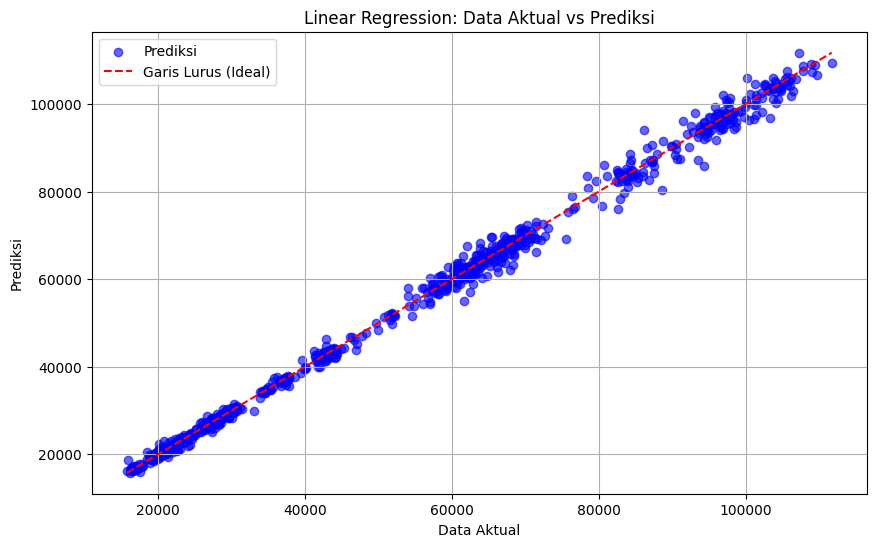

In [ ]:
import matplotlib.pyplot as plt

# predict using linear regression model
y_pred = linreg.predict(X_test)

# Plot data actual vs prediction
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Prediksi', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', label='Garis Lurus (Ideal)', linestyle='--')


plt.xlabel("Data Aktual")
plt.ylabel("Prediksi")
plt.title("Linear Regression: Data Aktual vs Prediksi")
plt.legend()
plt.grid(True)
plt.show()

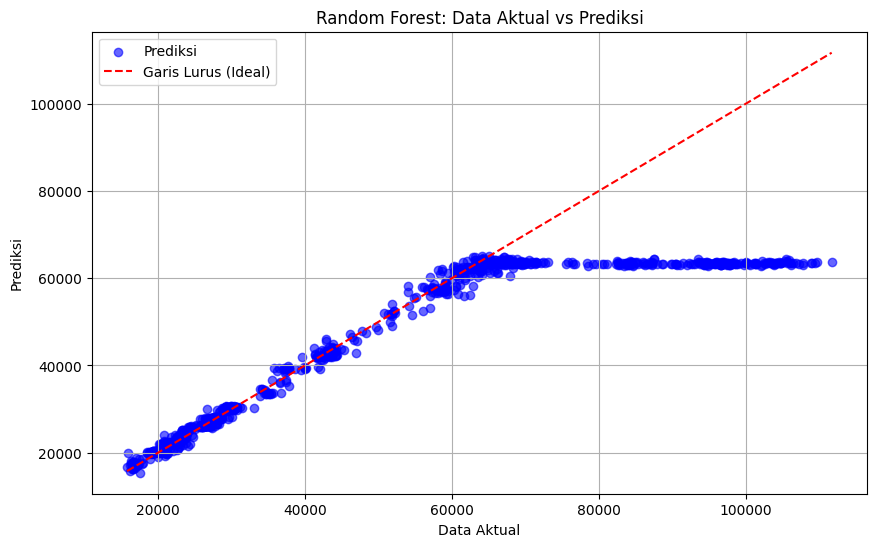

In [11]:
import matplotlib.pyplot as plt
import numpy as np

y_pred = rf_reg.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Prediksi', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', label='Garis Lurus (Ideal)', linestyle='--')

plt.xlabel("Data Aktual")
plt.ylabel("Prediksi")
plt.title("Random Forest: Data Aktual vs Prediksi")
plt.legend()
plt.grid(True)
plt.show()

Random Forest Seems to be underfit and stagnan on 65k price

-- save model

In [44]:
# Save model dan scaler
with open('../Model/price_prediction/linreg_model.pkl', 'wb') as f:
    pickle.dump(linreg, f)

with open('../Model/price_prediction/rf_reg_model.pkl', 'wb') as f:
    pickle.dump(rf_reg, f)

with open('../Model/price_prediction/scaler_price.pkl', 'wb') as f:
    pickle.dump(scaler, f)


# Hyperparameter Tuning / Tuning Model

we will tuning the model, my diagnose is:
1. Scaling data problem
maybe because the range from 0-110k price
2. adding technical indicator parameter such as ma7, ma30, volatility, and volume_ma does'nt give a good impact or just make noise on data.






- feature Selection

we eliminate unuseful features that did not give much impact, or only be noise and select the best features

In [115]:
from sklearn.feature_selection import RFE

X_full = df_processed[feature_columns]
y_full = df_processed['target']

linreg = LinearRegression()
rfe = RFE(estimator=linreg, n_features_to_select=6) 
rfe.fit(X_full, y_full)

print("Selected Features:", X_full.columns[rfe.support_])

Selected Features: Index(['price', 'open', 'high', 'low', 'change', 'volatility'], dtype='object')


- Retrain

start with linear regression

In [148]:
columns = ['price', 'open', 'high', 'low', 'volume', 'change', 'volatility']

X_full = df_processed[columns]
y_full = df_processed['target']

X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

linreg_model = LinearRegression()
linreg_model.fit(X_train, y_train)


LinearRegression()

In [149]:
y_pred = linreg_model.predict(X_test)
print("Linear Regression Model Evaluation After Feature Selection:")
print({"MAE": mean_absolute_error(y_test, y_pred),})
print({"RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),})
print({"R²": r2_score(y_test, y_pred),})

Linear Regression Model Evaluation After Feature Selection:
{'MAE': 381.93629471136467}
{'RMSE': np.float64(929.0575980851594)}
{'R²': 0.998434249767566}


- evaluate significance 

In [150]:
from sklearn.feature_selection import SelectKBest, f_regression

f_values, p_values = f_regression(X_full, y_full)
feature_importance = pd.DataFrame({'Feature': X_full.columns, 'F-Value': f_values, 'P-Value': p_values})
print(feature_importance)

      Feature       F-Value       P-Value
0       price  4.173203e+06  0.000000e+00
1        open  2.216407e+06  0.000000e+00
2        high  3.081077e+06  0.000000e+00
3         low  2.820636e+06  0.000000e+00
4      volume  2.899778e+01  7.552766e-08
5      change  1.514458e+00  2.185137e-01
6  volatility  9.560170e+03  0.000000e+00


volume & change seems to be not significance, but we will keep theese features

In [151]:
#predict 
linreg_modelPredictNext = linreg_model.predict(X_full)
print(f" Linear Regression Prediction Next === {linreg_modelPredictNext[-1]:.4f}")

 Linear Regression Prediction Next === 105481.2129


Linear regression is ok

              ----------------------------------------------------------------------------------------

              ----------------------------------------------------------------------------------------

- random forest

In [167]:
columns = ['price', 'open', 'high', 'low', 'volume', 'change']

X_full = df_processed[columns]
y_full = df_processed['target']

rf_reg.fit(X_sampled, y_sampled)



RandomForestRegressor(random_state=42)

In [208]:
eval_model(rf_reg, X_sampled, y_sampled, "Random Forest Regressor (Sampled Data)")


=== Random Forest Regressor (Sampled Data) ===
MAE : 715.9214642857069
RMSE: 1935.4264036995676
R²  : 0.9937694408037157


Mean Absolute Error (MAE): 715.92


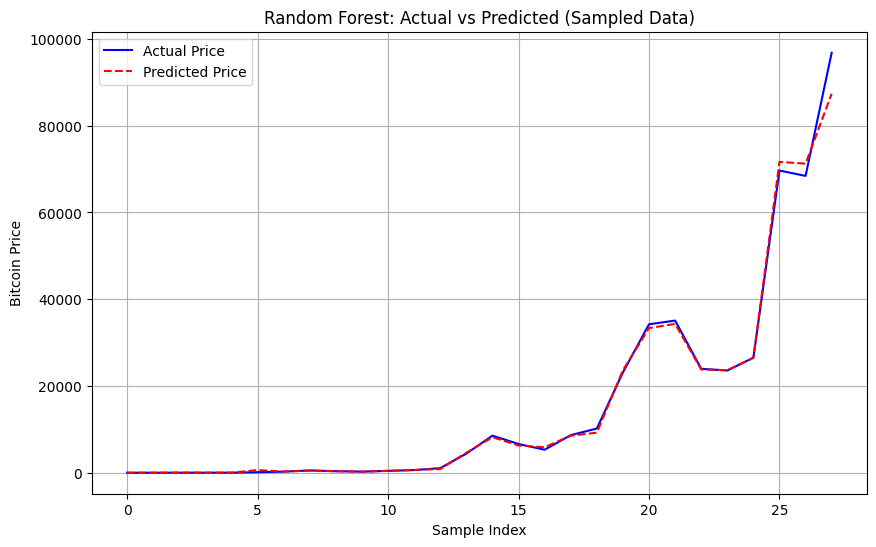

In [209]:
y_pred_sampled = rf_reg.predict(X_sampled)

mae = mean_absolute_error(y_sampled, y_pred_sampled)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

plt.figure(figsize=(10, 6))
plt.plot(y_sampled.values, label='Actual Price', color='blue')
plt.plot(y_pred_sampled, label='Predicted Price', color='red', linestyle='--')
plt.xlabel('Sample Index')
plt.ylabel('Bitcoin Price')
plt.title('Random Forest: Actual vs Predicted (Sampled Data)')
plt.legend()
plt.grid(True)
plt.show()

Random forest work much better using just price, open, high low, volume, change rather than adding features like ma7 ma30 volatility volume_ma.

In [171]:
#predict 
rf_predictNext = rf_reg.predict(X_full)
print(f" Random Forest Prediction Next === {rf_predictNext[-1]:.4f}")

 Random Forest Prediction Next === 84400.2610


but random forest still stuck in 80k, assuming the issue because of the distribution price on 100k is few

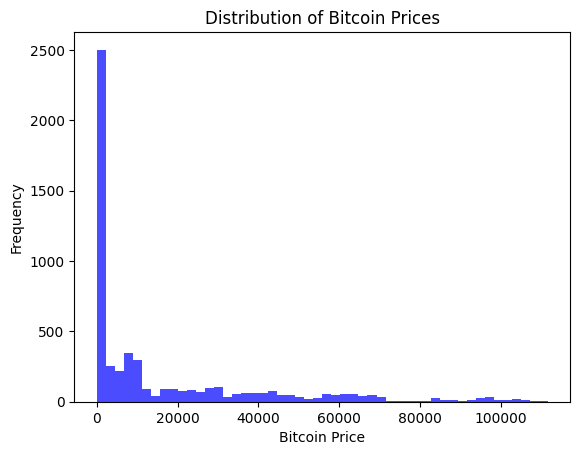

In [182]:

plt.hist(df['price'], bins=50, color='blue', alpha=0.7)
plt.xlabel('Bitcoin Price')
plt.ylabel('Frequency')
plt.title('Distribution of Bitcoin Prices')
plt.show()

# Train using XGboost

In [173]:
from xgboost import XGBRegressor

In [174]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=500, max_depth=10, learning_rate=2, random_state=42)
xgb_model.fit(X_full, y_full)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=2, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [176]:
# evaluation model for xgboost
eval_model(xgb_model, X_full, y_full, "XGBoost Regressor")


=== XGBoost Regressor ===
MAE : 3905.926730305989
RMSE: 6017.305574312452
R²  : 0.9393702931054297


In [181]:
xgboost_predictNext = xgb_model.predict(X_full)
print(f" XGBoost Prediction Next === {xgboost_predictNext[-1]:.4f}")

 XGBoost Prediction Next === 105482.6016
